In [1]:
from deeplab3.dataloaders import make_data_loader
from deeplab3.dataloaders import custom_transforms as tr
from deeplab3.dataloaders.utils import decode_segmap
from torch.utils.data import DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
import math
import os
import torch

import json
import datetime

from deeplab3.utils import model_utils

Visualize Darkening Effect
----

In [2]:
from deeplab3.config.defaults import get_cfg_defaults
cfg = get_cfg_defaults()
cfg.merge_from_file('../configs/cityscapes_rgbd.yaml')
cfg.merge_from_list(['DATASET.ROOT', '../datasets/cityscapes/'])

In [3]:
dataloaders = make_data_loader(cfg)

Using RGB-D input
Found 19997 train_extra images
Using RGB-D input
Found 500 val images
Using RGB-D input
Found 1525 test images


Text(0.5, 1.0, 'Original')

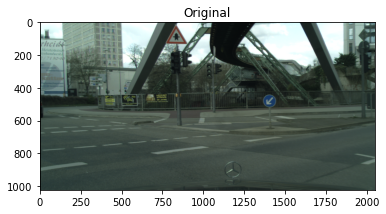

In [4]:
dataset = dataloaders[0].dataset
img_path, depth_path, label_path = dataset.get_path(2)
sample = dataset.loader.get_sample(img_path, depth_path, label_path)
image = sample['image']

plt.figure()
plt.imshow(image)
plt.title("Original")

### Different Darkening Degrees

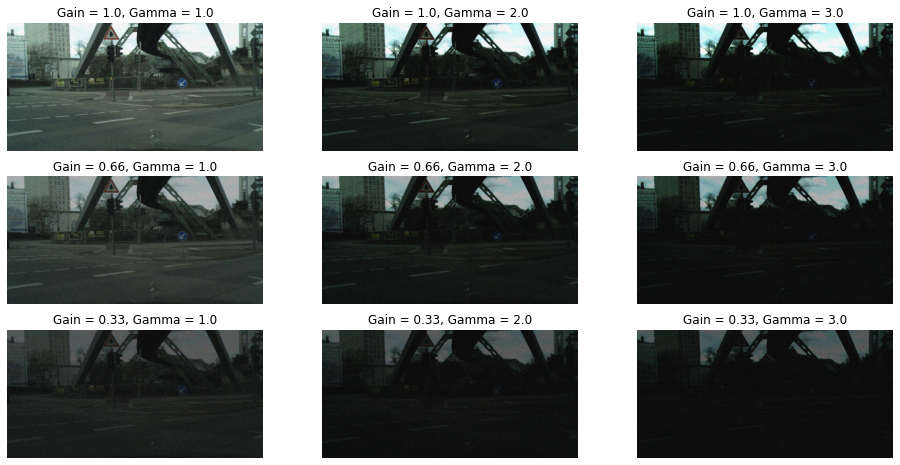

In [5]:
gain = [1.0, 0.66, 0.33]
gamma = [1.0, 2.0, 3.0]

plt.figure(figsize=(16, 8))

index = 1
for i in gain:
    for j in gamma:
        sample['image'] = image.copy()
        
        cfg = get_cfg_defaults()
        cfg.merge_from_list(['DATASET.DARKEN.DARKEN', True,
                            'DATASET.DARKEN.GAIN', float(i),
                            'DATASET.DARKEN.GAMMA', float(j)])
        f = tr.Darken(cfg)
        processed_sample = f(sample)
        
        plt.subplot(len(gain), len(gamma), index)
        plt.imshow(processed_sample['image'])
        plt.title("Gain = {}, Gamma = {}".format(i, j))
        plt.axis('off')
        
        index += 1

### RE-Brightened to visualize noise

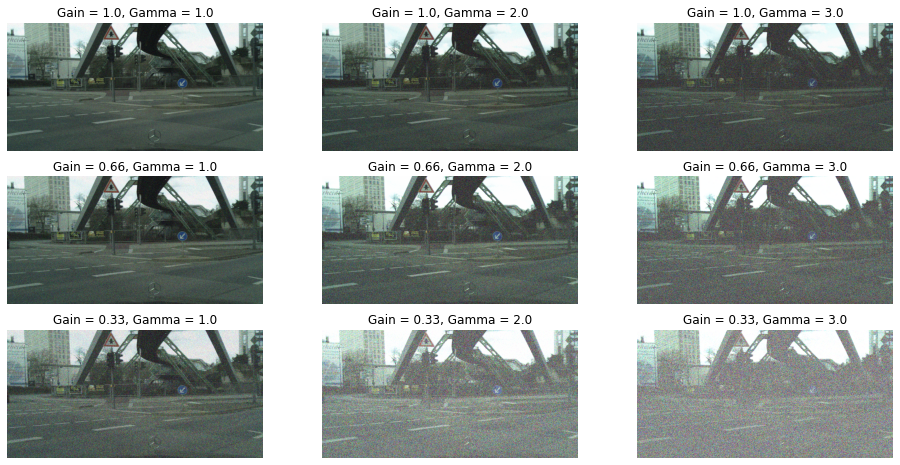

In [6]:
plt.figure(figsize=(16, 8))

index = 1
for i in gain:
    for j in gamma:
        sample['image'] = image.copy()
        
        cfg = get_cfg_defaults()
        cfg.merge_from_list(['DATASET.DARKEN.DARKEN', True,
                            'DATASET.DARKEN.GAIN', float(i),
                            'DATASET.DARKEN.GAMMA', float(j)])
        f = tr.Darken(cfg)
        processed_sample = f(sample)
        
        f = tr.UnDarken(cfg)
        processed_sample = f(processed_sample)
        
        plt.subplot(len(gain), len(gamma), index)
        plt.imshow(processed_sample['image'])
        plt.title("Gain = {}, Gamma = {}".format(i, j))
        plt.axis('off')
        index += 1

## Network Performance

In [7]:
model_configs = model_utils.get_all_models("../run/")
len(model_configs)

91

In [8]:
low_light_models = [ \
                    #Bright models 
                   '../run/cityscapes/cityscapes_rgbd_xception_fine_coarse/2020_08_20-15_58_16/parameters.yaml',
                   '../run/cityscapes/cityscapes_rgb_xception_pt_fine_coarse/2020_08_03-15_41_22/parameters.yaml',
                    '../run/scenenet/scenenet_rgbd_xception/2020_09_17-22_10_19/parameters.yaml',
                   '../run/scenenet/scenenet_rgb_xception/2020_09_17-22_14_43/parameters.yaml',
                    #Low-light models
                   '../run/cityscapes/cityscapes_rgbd_xception_low_light/2020_09_25-19_32_43/parameters.yaml',
                   '../run/cityscapes/cityscapes_rgb_xception_low_light/2020_09_25-19_36_53/parameters.yaml',
                   '../run/scenenet/scenenet_rgbd_xception_low_light/2020_09_25-23_11_51/parameters.yaml',
                   '../run/scenenet/scenenet_rgbd_xception_low_light/2020_09_28-08_36_05/parameters.yaml']

In [13]:
failed = []

metric_dict = {'RGB': { 'low-light': { 'scenenet': {i: {j : 0 for j in gamma} for i in gain},
                                        'cityscapes': {i: {j : 0 for j in gamma} for i in gain}},
                        'normal': { 'scenenet': {i: {j : 0 for j in gamma} for i in gain},
                                        'cityscapes': {i: {j : 0 for j in gamma} for i in gain}}} ,
               'RGBD' : { 'low-light': { 'scenenet': {i: {j : 0 for j in gamma} for i in gain},
                                        'cityscapes': {i: {j : 0 for j in gamma} for i in gain}},
                        'normal': { 'scenenet': {i: {j : 0 for j in gamma} for i in gain},
                                        'cityscapes': {i: {j : 0 for j in gamma} for i in gain}}}}

for index, cfg_filepath in enumerate(low_light_models):
    try:
        print(cfg_filepath)
        cfg = model_utils.match_cfg_versions(cfg_filepath)
        cfg.merge_from_list(['CHECKPOINT.DIRECTORY', os.path.dirname(cfg_filepath),
                             'TEST.MAX_ITER', 1000,
                             'MODEL.PRETRAINED', "",
                             'SYSTEM.GPU_IDS', [0]]) #Since we're using saved models, pretrained weights will be overwritten anyway.

        for i in gain:
            for j in gamma:
                low = "low-light" if index>3 else "normal"
                
                cfg.merge_from_list(['DATASET.DARKEN.DARKEN', True,
                                    'DATASET.DARKEN.GAIN', float(i),
                                    'DATASET.DARKEN.GAMMA', float(j)])
        
                model_filepath = os.path.join(cfg.CHECKPOINT.DIRECTORY, cfg.CHECKPOINT.MODEL)
                checkpoint = torch.load(model_filepath, map_location=torch.device('cpu'))
                
                result_file = os.path.join(cfg.CHECKPOINT.DIRECTORY, 'validation_report_gain{:3.2f}_gamma{:3.2f}.txt'.format(float(i), float(j)))
                checkpoint_file = os.path.join(cfg.CHECKPOINT.DIRECTORY, 'checkpoint.pth.tar')
                if os.path.exists(result_file) and (os.path.getmtime(result_file) > os.path.getmtime(checkpoint_file)):
                    with open(result_file, 'r') as fp:
                        metric_str = fp.read().split('{')[1].split('}')[0].replace("'", '"')
                        metrics = json.loads('{' + metric_str + '}')
                    print("Success on {} {} {} {} {}".format(cfg.DATASET.MODE, low, cfg.DATASET.NAME, i, j))
                else:
                    metrics = {'mIoU': 0}
                    print("Failed to load {}".format(result_file))
                    #metrics = model_utils.test_model(cfg, result_file)

                metric_dict[cfg.DATASET.MODE][low][cfg.DATASET.NAME][i][j] = metrics['mIoU']
        
    except Exception as e:
        print(e)
        print(cfg_filepath)
        failed.append(cfg_filepath)
        

../run/cityscapes/cityscapes_rgbd_xception_fine_coarse/2020_08_20-15_58_16/parameters.yaml
Non-existent key: DATASET.CITYSCAPES.TEST_SET
Success on RGBD normal cityscapes 1.0 1.0
Success on RGBD normal cityscapes 1.0 2.0
Success on RGBD normal cityscapes 1.0 3.0
Success on RGBD normal cityscapes 0.66 1.0
Success on RGBD normal cityscapes 0.66 2.0
Success on RGBD normal cityscapes 0.66 3.0
Success on RGBD normal cityscapes 0.33 1.0
Success on RGBD normal cityscapes 0.33 2.0
Success on RGBD normal cityscapes 0.33 3.0
../run/cityscapes/cityscapes_rgb_xception_pt_fine_coarse/2020_08_03-15_41_22/parameters.yaml
Success on RGB normal cityscapes 1.0 1.0
Success on RGB normal cityscapes 1.0 2.0
Success on RGB normal cityscapes 1.0 3.0
Success on RGB normal cityscapes 0.66 1.0
Success on RGB normal cityscapes 0.66 2.0
Success on RGB normal cityscapes 0.66 3.0
Success on RGB normal cityscapes 0.33 1.0
Success on RGB normal cityscapes 0.33 2.0
Success on RGB normal cityscapes 0.33 3.0
../run/scen

In [14]:
metric_dict

{'RGB': {'low-light': {'scenenet': {1.0: {1.0: 0.31819347877830717,
     2.0: 0.33439417240456837,
     3.0: 0.31616709773298035},
    0.66: {1.0: 0.3335665724401795,
     2.0: 0.3320294099511369,
     3.0: 0.30397413764770614},
    0.33: {1.0: 0.28952258780935836,
     2.0: 0.2858426826484964,
     3.0: 0.25857508422546893}},
   'cityscapes': {1.0: {1.0: 0.426904946772556,
     2.0: 0.40202097375097573,
     3.0: 0.32526644441511415},
    0.66: {1.0: 0.42734700986053736,
     2.0: 0.3866839745820882,
     3.0: 0.3022709752103692},
    0.33: {1.0: 0.3759897004220583,
     2.0: 0.32239081273189657,
     3.0: 0.2421746328125667}}},
  'normal': {'scenenet': {1.0: {1.0: 0.19989035352554366,
     2.0: 0.20486736498575953,
     3.0: 0.17521520561127948},
    0.66: {1.0: 0.17894917928113832,
     2.0: 0.17057107763049545,
     3.0: 0.13396344313924405},
    0.33: {1.0: 0.09475039469760364,
     2.0: 0.07469174863522408,
     3.0: 0.052137272890282964}},
   'cityscapes': {1.0: {1.0: 0.02454174

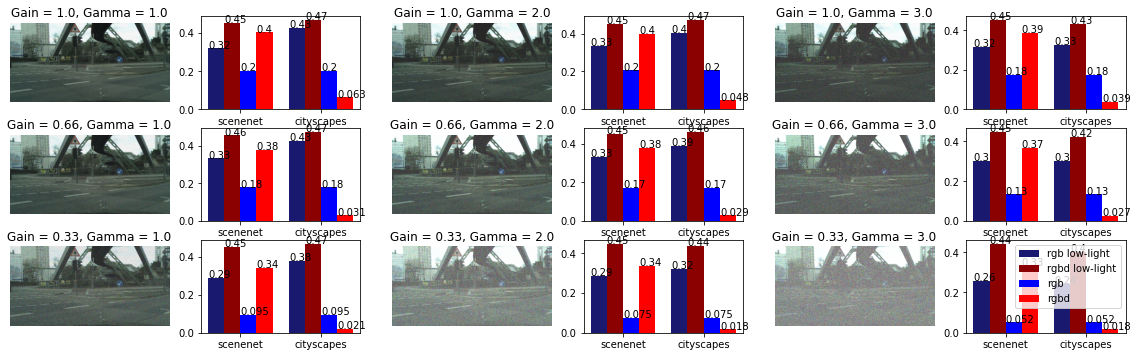

In [15]:
plt.figure(figsize=(20, 12))

index = 1
for i in gain:
    for j in gamma:
        sample['image'] = image.copy()
        
        cfg = get_cfg_defaults()
        cfg.merge_from_list(['DATASET.DARKEN.DARKEN', True,
                            'DATASET.DARKEN.GAIN', float(i),
                            'DATASET.DARKEN.GAMMA', float(j)])
        f = tr.Darken(cfg)
        processed_sample = f(sample)
        
        f = tr.UnDarken(cfg)
        processed_sample = f(processed_sample)
        
        plt.subplot(len(gain)*2, len(gamma)*2, index)
        plt.imshow(processed_sample['image'])
        plt.title("Gain = {}, Gamma = {}".format(i, j))
        plt.axis('off')
        index += 1
        
        labels = ['scenenet', 'cityscapes']
                
        y_pos = np.arange(2)
        width = 0.20
        
        ax1 = plt.subplot(len(gain)*2, len(gamma)*2, index)
        ax1.bar(y_pos - 2*width, [metric_dict['RGB']['low-light']['scenenet'][i][j], 
                                 metric_dict['RGB']['low-light']['cityscapes'][i][j]], 
                width=width, color='midnightblue', label="rgb low-light")
        ax1.bar(y_pos - width, [metric_dict['RGBD']['low-light']['scenenet'][i][j], 
                                metric_dict['RGBD']['low-light']['cityscapes'][i][j]], 
                width=width, color='darkred', label="rgbd low-light")
        ax1.bar(y_pos, [metric_dict['RGB']['normal']['scenenet'][i][j], 
                        metric_dict['RGB']['normal']['scenenet'][i][j]], 
                width=width, color='blue', label="rgb")
        ax1.bar(y_pos + width, [metric_dict['RGBD']['normal']['scenenet'][i][j], 
                                metric_dict['RGBD']['normal']['cityscapes'][i][j]],
                width=width, color='red', label="rgbd")
    
        ax1.set_xticks(y_pos - 0.1)
        ax1.set_xticklabels(labels)
        
        for p in ax1.patches:
            if p.get_height() > 0 :
                ax1.annotate("{:3.2}".format(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))
            
        index += 1
        
ax1.legend()

In [9]:
failed = []

metric_dict = {'RGB': { 'low-light': { 'scenenet': 0.0,
                                        'cityscapes': 0.0},
                        'normal': { 'scenenet': 0.0,
                                        'cityscapes': 0.0}} ,
               'RGBD' : { 'low-light': { 'scenenet': 0.0,
                                        'cityscapes': 0.0},
                        'normal': { 'scenenet': 0.0,
                                        'cityscapes': 0.0}}}

for index, cfg_filepath in enumerate(low_light_models):
    try:
        print(cfg_filepath)
        cfg = model_utils.match_cfg_versions(cfg_filepath)
        cfg.merge_from_list(['CHECKPOINT.DIRECTORY', os.path.dirname(cfg_filepath),
                             'TEST.MAX_ITER', 1000,
                             'MODEL.PRETRAINED', "",
                             'SYSTEM.GPU_IDS', [0]]) #Since we're using saved models, pretrained weights will be overwritten anyway.

        low = "low-light" if index>3 else "normal"

        cfg.merge_from_list(['DATASET.DARKEN.DARKEN', False])

        model_filepath = os.path.join(cfg.CHECKPOINT.DIRECTORY, cfg.CHECKPOINT.MODEL)
        checkpoint = torch.load(model_filepath, map_location=torch.device('cpu'))

        result_file = os.path.join(cfg.CHECKPOINT.DIRECTORY, 'validation_report.txt')
        checkpoint_file = os.path.join(cfg.CHECKPOINT.DIRECTORY, 'checkpoint.pth.tar')
        if os.path.exists(result_file) and (os.path.getmtime(result_file) > os.path.getmtime(checkpoint_file)):
            with open(result_file, 'r') as fp:
                metric_str = fp.read().split('{')[1].split('}')[0].replace("'", '"')
                metrics = json.loads('{' + metric_str + '}')
            print("Success on {} {} {} ".format(cfg.DATASET.MODE, low, cfg.DATASET.NAME))
        else:
            metrics = {'mIoU': 0}
            print("Failed to load {}".format(result_file))
            #metrics = model_utils.test_model(cfg, result_file)

        metric_dict[cfg.DATASET.MODE][low][cfg.DATASET.NAME] = metrics['mIoU']
        
    except Exception as e:
        print(e)
        print(cfg_filepath)
        failed.append(cfg_filepath)

../run/cityscapes/cityscapes_rgbd_xception_fine_coarse/2020_08_20-15_58_16/parameters.yaml
Non-existent key: DATASET.CITYSCAPES.TEST_SET
Success on RGBD normal cityscapes 
../run/cityscapes/cityscapes_rgb_xception_pt_fine_coarse/2020_08_03-15_41_22/parameters.yaml


/home/cecilia/pytorch-deeplab-xception/deeplab3/utils/model_utils.py:39: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  model_cfg = yaml.load(f)


Success on RGB normal cityscapes 
../run/scenenet/scenenet_rgbd_xception/2020_09_17-22_10_19/parameters.yaml
Non-existent key: DATASET.CITYSCAPES.TEST_SET
Success on RGBD normal scenenet 
../run/scenenet/scenenet_rgb_xception/2020_09_17-22_14_43/parameters.yaml
Success on RGB normal scenenet 
../run/cityscapes/cityscapes_rgbd_xception_low_light/2020_09_25-19_32_43/parameters.yaml
Success on RGBD low-light cityscapes 
../run/cityscapes/cityscapes_rgb_xception_low_light/2020_09_25-19_36_53/parameters.yaml
Success on RGB low-light cityscapes 
../run/scenenet/scenenet_rgbd_xception_low_light/2020_09_25-23_11_51/parameters.yaml
Success on RGBD low-light scenenet 
../run/scenenet/scenenet_rgbd_xception_low_light/2020_09_28-08_36_05/parameters.yaml
Success on RGB low-light scenenet 


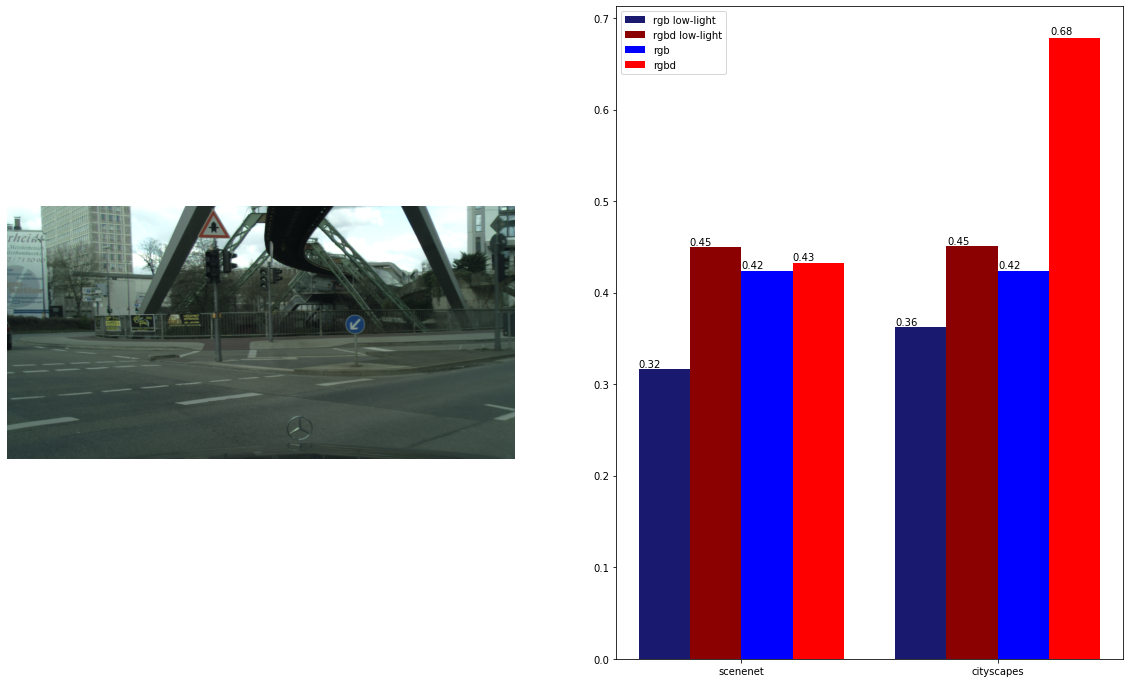

In [12]:
plt.figure(figsize=(20, 12))

index = 1
sample['image'] = image.copy()

cfg = get_cfg_defaults()
cfg.merge_from_list(['DATASET.DARKEN.DARKEN', False])
#         f = tr.Darken(cfg)
#         processed_sample = f(sample)
        
#         f = tr.UnDarken(cfg)
#         processed_sample = f(processed_sample)
        
plt.subplot(1, 2, 1)
plt.imshow(sample['image'])
#         plt.title("Gain = {}, Gamma = {}".format(i, j))
plt.axis('off')
index += 1

labels = ['scenenet', 'cityscapes']

y_pos = np.arange(2)
width = 0.20

ax1 = plt.subplot(1, 2, 2)
ax1.bar(y_pos - 2*width, [metric_dict['RGB']['low-light']['scenenet'], 
                         metric_dict['RGB']['low-light']['cityscapes']], 
        width=width, color='midnightblue', label="rgb low-light")
ax1.bar(y_pos - width, [metric_dict['RGBD']['low-light']['scenenet'], 
                        metric_dict['RGBD']['low-light']['cityscapes']], 
        width=width, color='darkred', label="rgbd low-light")
ax1.bar(y_pos, [metric_dict['RGB']['normal']['scenenet'], 
                metric_dict['RGB']['normal']['scenenet']], 
        width=width, color='blue', label="rgb")
ax1.bar(y_pos + width, [metric_dict['RGBD']['normal']['scenenet'], 
                        metric_dict['RGBD']['normal']['cityscapes']],
        width=width, color='red', label="rgbd")

ax1.set_xticks(y_pos - 0.1)
ax1.set_xticklabels(labels)

for p in ax1.patches:
    if p.get_height() > 0 :
        ax1.annotate("{:3.2}".format(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

index += 1
        
ax1.legend()